# 1. Install requirements

In [1]:
!pip install -r requirements.txt

# 2. Import libraries

In [2]:
from typing import Dict, List, Tuple, Union
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
from transformers import get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, balanced_accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

Зафиксируем сид для воспроизводимости решения

In [3]:
SEED = 42


def seed_all(seed_value: int = 42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = False


seed_all(SEED)

# 3. Data

In [4]:
data = pd.read_csv("data.txt")
data

,password,strength
0,yrtzuab476,1
1,yEdnN9jc1NgzkkBP,2
2,sarita99,1
3,Suramerica2015,2
4,PPRbMvDIxMQ19TMo,2
...,...,...
99995,aulona044,1
99996,5201314ding,1
99997,isaac19725,1
99998,toji25,0


# 4. EDA

In [5]:
from collections import Counter

def get_char_statistics(passwords: List[str]) -> Dict[str, int]:
    all_characters = list("".join(passwords.to_list()))
    statistics = dict(sorted(Counter(all_characters).items(), key=lambda x: x[1], reverse=True))
    return statistics


char_statistics = get_char_statistics(data.password)


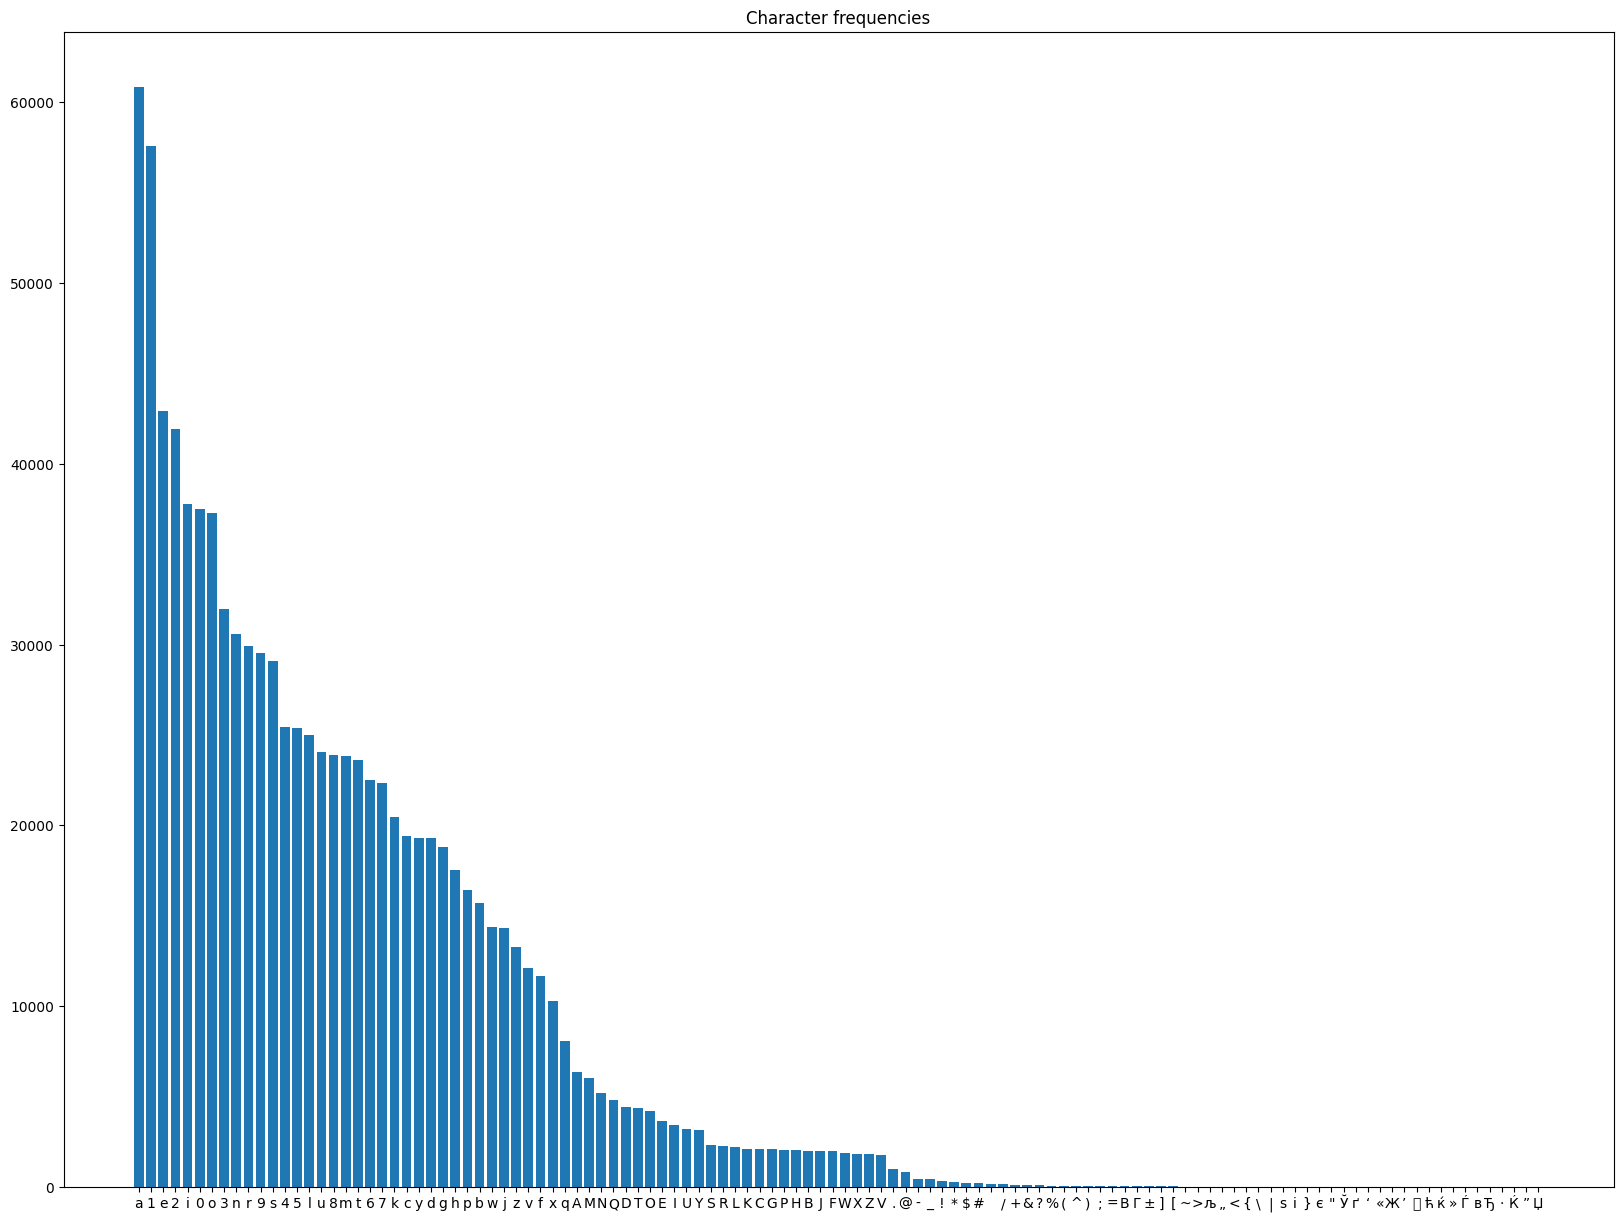

In [6]:
fig, ax = plt.subplots(figsize=(20, 15))

chars = list(char_statistics.keys())
stats = list(char_statistics.values())

ax.bar(chars, stats)
plt.title('Character frequencies')

plt.show()

<Axes: title={'center': 'Target distribution'}, xlabel='strength'>

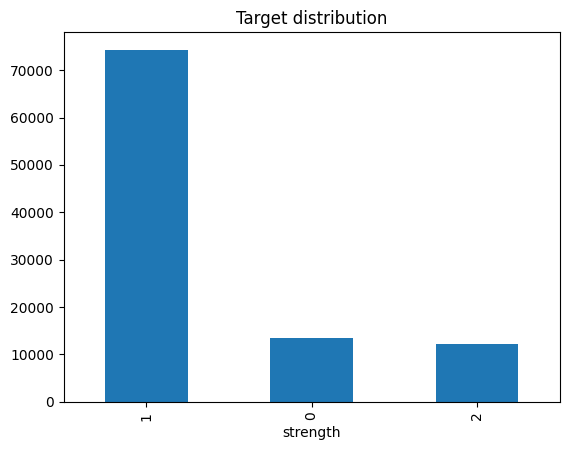

In [7]:
plt.title('Target distribution')
data.strength.value_counts().plot(kind='bar')

Виден явный дизбаланс классов

Text(0.5, 1.0, 'Password length distribution')

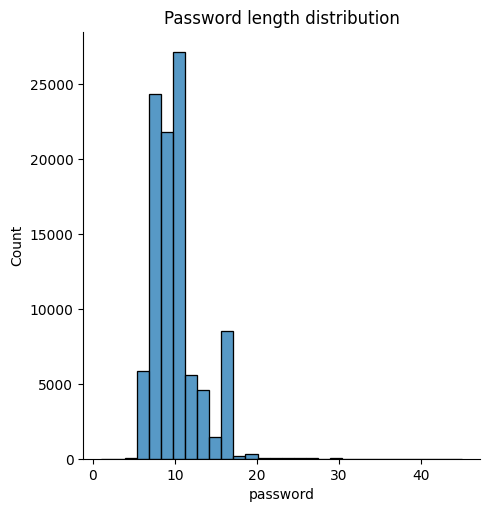

In [8]:
sns.displot(data.password.apply(lambda x: len(x)), bins=30)
plt.title('Password length distribution')

# 5. Tokenization

In [9]:
char_to_id = {char: id for id, char in enumerate(list(char_statistics.keys()))}
char_to_id

{'a': 0,
 '1': 1,
 'e': 2,
 '2': 3,
 'i': 4,
 '0': 5,
 'o': 6,
 '3': 7,
 'n': 8,
 'r': 9,
 '9': 10,
 's': 11,
 '4': 12,
 '5': 13,
 'l': 14,
 'u': 15,
 '8': 16,
 'm': 17,
 't': 18,
 '6': 19,
 '7': 20,
 'k': 21,
 'c': 22,
 'y': 23,
 'd': 24,
 'g': 25,
 'h': 26,
 'p': 27,
 'b': 28,
 'w': 29,
 'j': 30,
 'z': 31,
 'v': 32,
 'f': 33,
 'x': 34,
 'q': 35,
 'A': 36,
 'M': 37,
 'N': 38,
 'Q': 39,
 'D': 40,
 'T': 41,
 'O': 42,
 'E': 43,
 'I': 44,
 'U': 45,
 'Y': 46,
 'S': 47,
 'R': 48,
 'L': 49,
 'K': 50,
 'C': 51,
 'G': 52,
 'P': 53,
 'H': 54,
 'B': 55,
 'J': 56,
 'F': 57,
 'W': 58,
 'X': 59,
 'Z': 60,
 'V': 61,
 '.': 62,
 '@': 63,
 '-': 64,
 '_': 65,
 '!': 66,
 '*': 67,
 '$': 68,
 '#': 69,
 ' ': 70,
 '/': 71,
 '+': 72,
 '&': 73,
 '?': 74,
 '%': 75,
 '(': 76,
 '^': 77,
 ')': 78,
 ';': 79,
 '=': 80,
 'В': 81,
 'Г': 82,
 '±': 83,
 ']': 84,
 '[': 85,
 '~': 86,
 '>': 87,
 'љ': 88,
 '„': 89,
 '<': 90,
 '{': 91,
 '\\': 92,
 '|': 93,
 'ѕ': 94,
 'і': 95,
 '}': 96,
 'є': 97,
 '"': 98,
 'Ў': 99,
 'ґ': 100

In [10]:
VOCAB_SIZE = len(list(char_to_id.keys())) + 1 # 116 chars and [PAD]
VOCAB_SIZE

117

In [11]:
MAX_LEN = data.password.apply(lambda x: len(x)).max()
MAX_LEN

45

In [12]:
PAD = VOCAB_SIZE - 1

# 6. Преобразования данных

1) Считаем следующие статистики по паролю: кол-во букв, кол-во цифр, кол-во спец символов а также кол-во заглавных букв
2) Каждый символ заменяет на соответствующий ему id'шник (всего у нас id'шников ```VOCAB_SIZE = 117```)
3) Делаем паддинг до ранее вычисленного ```MAX_LEN = 45```

In [13]:
def get_meta_features(chars: List[str]) -> List[int]:
    letters = 0.0
    numbers = 0.0
    capitals = 0.0
    special_symbols = 0.0
    
    for char in chars:
        if char.isalpha():
            letters += 1
            if char.lower() != char:
                capitals += 1
                
        elif char.isnumeric():
            numbers += 1

        else:
            special_symbols += 1

    return [letters, numbers, capitals, special_symbols]


def preprocess_password(word: str) -> Tuple[torch.Tensor]:
    chars = list(word)
    meta_features = get_meta_features(word)
    ids = [char_to_id[char] for char in chars]
    
    attn_mask = [1] * len(ids) + [0] * (MAX_LEN - len(ids))
    pads = [PAD] * (MAX_LEN - len(ids))
    ids = ids + pads

    return torch.LongTensor(ids).unsqueeze(0), torch.LongTensor(attn_mask).unsqueeze(0), torch.FloatTensor(meta_features).unsqueeze(0)
    

In [14]:
preprocess_password(data.password[0])

(tensor([[ 23,   9,  18,  31,  15,   0,  28,  12,  20,  19, 116, 116, 116, 116,
          116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116,
          116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116,
          116, 116, 116]]),
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 tensor([[7., 3., 0., 0.]]))

In [15]:
def build_dataset(data: pd.DataFrame) -> TensorDataset:
    train_dataset_ids, train_dataset_attn_mask, train_dataset_meta_features = [], [], []
    
    for word in tqdm(data.password):
        sample_ids, sample_attn_mask, meta_feature = preprocess_password(word)
        train_dataset_ids.append(sample_ids)
        train_dataset_attn_mask.append(sample_attn_mask)
        train_dataset_meta_features.append(meta_feature)
    
    train_dataset_ids, train_dataset_attn_mask, train_dataset_meta_features = torch.cat(train_dataset_ids, dim=0), torch.cat(train_dataset_attn_mask, dim=0), torch.cat(train_dataset_meta_features, dim=0)
    labels = torch.from_numpy(data.strength.to_numpy())

    dataset = TensorDataset(train_dataset_ids, train_dataset_attn_mask, train_dataset_meta_features, labels)
    
    return dataset

In [16]:
dataset = build_dataset(data)

  0%|          | 0/100000 [00:00<?, ?it/s]

# 7. Model

В качестве модели я реализую Bidirectional LSTM c Attention'ом. Которая помимо обработки предпосчитанных статистик может уловить закономерности в порядке символов.

В данной задаче ее главное преимущество над трансформером заключается в том, что у нее меньше обучаемых параметров и поэтому на такой выборке она быстрее сойдется и с лучшим качеством. А Attention позволит моделе не обращать внимание на PAD токены.

Так же модель будет принимать на вход вектор верхнеуровневых признаков из пункта 5.

In [17]:
class AttentionPooling(nn.Module):
    def __init__(self, hidden_dim: int = 64):
        super().__init__()
        
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1),
            nn.ReLU(),
        )
        
    def forward(self, x: torch.FloatTensor, attention_mask: torch.LongTensor) -> torch.FloatTensor:
        attention_scores = torch.softmax(self.attention(x) * attention_mask.unsqueeze(dim=-1), dim=-2)
        x = (x * attention_scores).sum(dim=-2)
        return x


class StrengthLSTM(nn.Module):
    def __init__(self, hidden_dim: int = 64, meta_features_dim: int = 4, num_layers: int = 1, output_dim: int = 3, bidirectional: bool = True):
        super().__init__()
        
        self.embedding = nn.Embedding(VOCAB_SIZE, hidden_dim)
        
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
        )
        
        self.attention_pooling = AttentionPooling(hidden_dim=hidden_dim * (1 + bidirectional))

        self.meta_features_encoder = nn.Sequential(
            nn.BatchNorm1d(meta_features_dim),
            nn.Linear(meta_features_dim, hidden_dim)
        )
        
        self.out = nn.Linear(hidden_dim * (2 + bidirectional), output_dim)

    def forward(self, input_ids: torch.LongTensor, attention_mask: torch.LongTensor, meta_features: torch.FloatTensor) -> torch.FloatTensor:
        x = self.embedding(input_ids)
        x, (h, c) = self.lstm(x)
        
        pooled_x = self.attention_pooling(x, attention_mask)
        meta_x = self.meta_features_encoder(meta_features)
        
        out = self.out(torch.cat([pooled_x, meta_x], dim=-1))
        
        return out

In [18]:
model = StrengthLSTM(
    hidden_dim=64, 
    num_layers=2, 
    meta_features_dim=4,
    output_dim=3, 
    bidirectional=True,
)

model

StrengthLSTM(
  (embedding): Embedding(117, 64)
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True, bidirectional=True)
  (attention_pooling): AttentionPooling(
    (attention): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=128, out_features=1, bias=True)
      (3): ReLU()
    )
  )
  (meta_features_encoder): Sequential(
    (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=4, out_features=64, bias=True)
  )
  (out): Linear(in_features=192, out_features=3, bias=True)
)

# 8. Loops

In [19]:
def train_epoch(model, data_loader, loss_function, optimizer, scheduler, device, n_acum_steps = 1):
    model.to(device)
    model.train()
    total_train_loss = 0

    dl_size = len(data_loader)
    
    preds = []
    targets = []

    batch_i = 0
    for batch in tqdm(data_loader):
        input_ids, attention_masks, meta_features, target = batch
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        meta_features = meta_features.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()        
        logits = model(input_ids, attention_masks, meta_features)
                
        preds.append(logits.argmax(dim=1).detach().cpu())
        targets.append(target.cpu())
                
        loss = loss_function(logits, target) / n_acum_steps
        total_train_loss += loss.item()
        
        loss.backward()
        if batch_i % n_acum_steps == 0 or batch_i == len(data_loader.dataset): 
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        batch_i += 1

    preds = torch.cat(preds, dim=0).numpy()
    targets = torch.cat(targets, dim=0).numpy()
    balanced_acc = balanced_accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average="weighted")

    metrics = {
        "Train Loss": total_train_loss / dl_size,
        "Train Balanced Accuracy": balanced_acc,
        "Train F1": f1,
    }
    
    return metrics
    
    
def eval_epoch(model, data_loader, loss_function, device):
    model.to(device)
    model.eval()
    total_train_loss = 0
    
    preds = []
    targets = []

    dl_size = len(data_loader)

    
    for batch in tqdm(data_loader):
        input_ids, attention_masks, meta_features, target = batch
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        meta_features = meta_features.to(device)
        target = target.to(device)
        
        with torch.no_grad():
            logits = model(input_ids, attention_masks, meta_features)
            preds.append(logits.argmax(dim=1).cpu())
            targets.append(target.cpu())
        
        loss = loss_function(logits, target)
        total_train_loss += loss.item()
            
    preds = torch.cat(preds, dim=0).numpy()
    targets = torch.cat(targets, dim=0).numpy()
    balanced_acc = balanced_accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average="weighted")
    
    metrics = {
        "Eval Loss": total_train_loss / dl_size,
        "Eval Balanced Accuracy": balanced_acc,
        "Eval F1": f1,
    }
    
    return metrics


def single_model(model, 
                 train_dataset, 
                 eval_dataset,  
                 loss_function, 
                 optimizer,
                 get_scheduler,
                 device: Union[torch.device, str] = torch.device("cuda"),
                 random_state: int = 69, 
                 shuffle: bool = True, 
                 epochs: int = 5, 
                 lr: float = 1e-6,
                 num_workers: int = 1,
                 batch_size: int = 32,
                 n_acum_steps: int = 0):
    loss_function.to(device)

    train_loader = torch.utils.data.DataLoader(
                  train_dataset, 
                  batch_size=batch_size,
                  shuffle=shuffle,
                  num_workers=num_workers
    )

    eval_loader = torch.utils.data.DataLoader(
                  eval_dataset,
                  batch_size=batch_size,
                  shuffle=False,
                  num_workers=num_workers
    )
    
    total_steps = len(train_loader) * epochs 

    scheduler = get_scheduler(optimizer, 
                                        num_warmup_steps = 0, # Default value in run_glue.py
                                        num_training_steps = total_steps)

    for epoch_i in range(0, epochs):
        train_metrics = train_epoch(model, train_loader, loss_function, optimizer, scheduler, device, n_acum_steps)
        eval_metrics = eval_epoch(model, eval_loader, loss_function, device)
        
        print(f"EPOCH: {epoch_i}")
        print(train_metrics)
        print(eval_metrics)


Поскольку распределение таргета несбалансировано, стратифицируем разделение на train, test по таргету

In [20]:
train_inds, eval_inds = train_test_split([i for i in range(len(dataset))], stratify=data.strength, test_size=0.2, random_state=SEED)
train_dataset = Subset(dataset, indices=train_inds)
eval_dataset = Subset(dataset, indices=eval_inds)

len(train_inds), len(eval_inds)

(80000, 20000)

In [21]:
model = StrengthLSTM(
    hidden_dim=64, 
    num_layers=2,
    meta_features_dim=4,
    output_dim=3, 
    bidirectional=True,
)

optimizer = torch.optim.AdamW([
    {"params": model.embedding.parameters(), "lr" : 1e-4},
    {"params": model.lstm.parameters(), "lr" : 1e-4},
    {"params": model.out.parameters(), "lr" : 1e-4},
])

get_scheduler = get_cosine_schedule_with_warmup

В пайплайне присутствуют реализованы: обучение, валидация, косинусный шедулер, аккумуляция градиентов (для симмуляции бОльших батчей) 

Из пункта 4. следует, что таргет дисбалансный, следовательно Accuracy будет высоким из-за дизбаланса и не отразит реального качества нашего классификатора. Поэтому качестве метрики выбраны Accuracy и Weighted F1, которые устойчивы к дизбалансу классов.

In [ ]:
single_model(
    model=model, 
    train_dataset=train_dataset, 
    eval_dataset=eval_dataset,   
    loss_function=nn.CrossEntropyLoss(), 
    optimizer=optimizer,
    get_scheduler=get_scheduler,
    device=torch.device("cpu"),
    random_state=SEED, 
    shuffle=True, 
    epochs=10, 
    num_workers=0,
    batch_size=128,
    n_acum_steps=1   
)

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

EPOCH: 0
{'Train Loss': 0.47373441146612166, 'Train Balanced Accuracy': 0.5998956994191396, 'Train F1': 0.8096415701774291}
{'Eval Loss': 0.07086125675849854, 'Eval Balanced Accuracy': 0.968130236770994, 'Eval F1': 0.9866652340037056}


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

EPOCH: 1
{'Train Loss': 0.03479155773669481, 'Train Balanced Accuracy': 0.9918221197111063, 'Train F1': 0.9943762637999575}
{'Eval Loss': 0.019971698498839785, 'Eval Balanced Accuracy': 0.994653827175095, 'Eval F1': 0.9958523521188803}


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

EPOCH: 2
{'Train Loss': 0.011453729507327079, 'Train Balanced Accuracy': 0.9971178229740932, 'Train F1': 0.9980501257301532}
{'Eval Loss': 0.012226268038106192, 'Eval Balanced Accuracy': 0.9925348066876132, 'Eval F1': 0.9968891614294129}


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

EPOCH: 3
{'Train Loss': 0.007860642849095165, 'Train Balanced Accuracy': 0.9979162291712118, 'Train F1': 0.9985376483583673}
{'Eval Loss': 0.00547466480549852, 'Eval Balanced Accuracy': 0.9987713502910962, 'Eval F1': 0.9991002437074274}


  0%|          | 0/625 [00:00<?, ?it/s]